# Figure 6- V2 over time

Want to show the violation rates are stable for V2 animals over long periods of time


In [89]:
import config as c
import utils as u
# import behav_viz.ingest as ingest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load


In [94]:
tdf = pd.read_parquet("data/V2_tdf_continued_stage_11.parquet")

tdf["days_relative_to_stage_11_adj"] = tdf["days_relative_to_stage_11"] + 1

In [95]:
tdf.groupby("animal_id").days_relative_to_stage_11.max()

animal_id
R041    179
R043    183
R045    171
R047    160
R049    164
R051    178
R055    161
R057    177
Name: days_relative_to_stage_11, dtype: int64

# 1. Example Stage 11 Fix Durs over Sessions


In [97]:
EXAMPLE_ANIMAL = "R043"

example_tdf = tdf.query("animal_id == @EXAMPLE_ANIMAL").copy()
example_tdf["cumulative_trial"] = example_tdf.groupby("animal_id").trial.cumcount() + 1

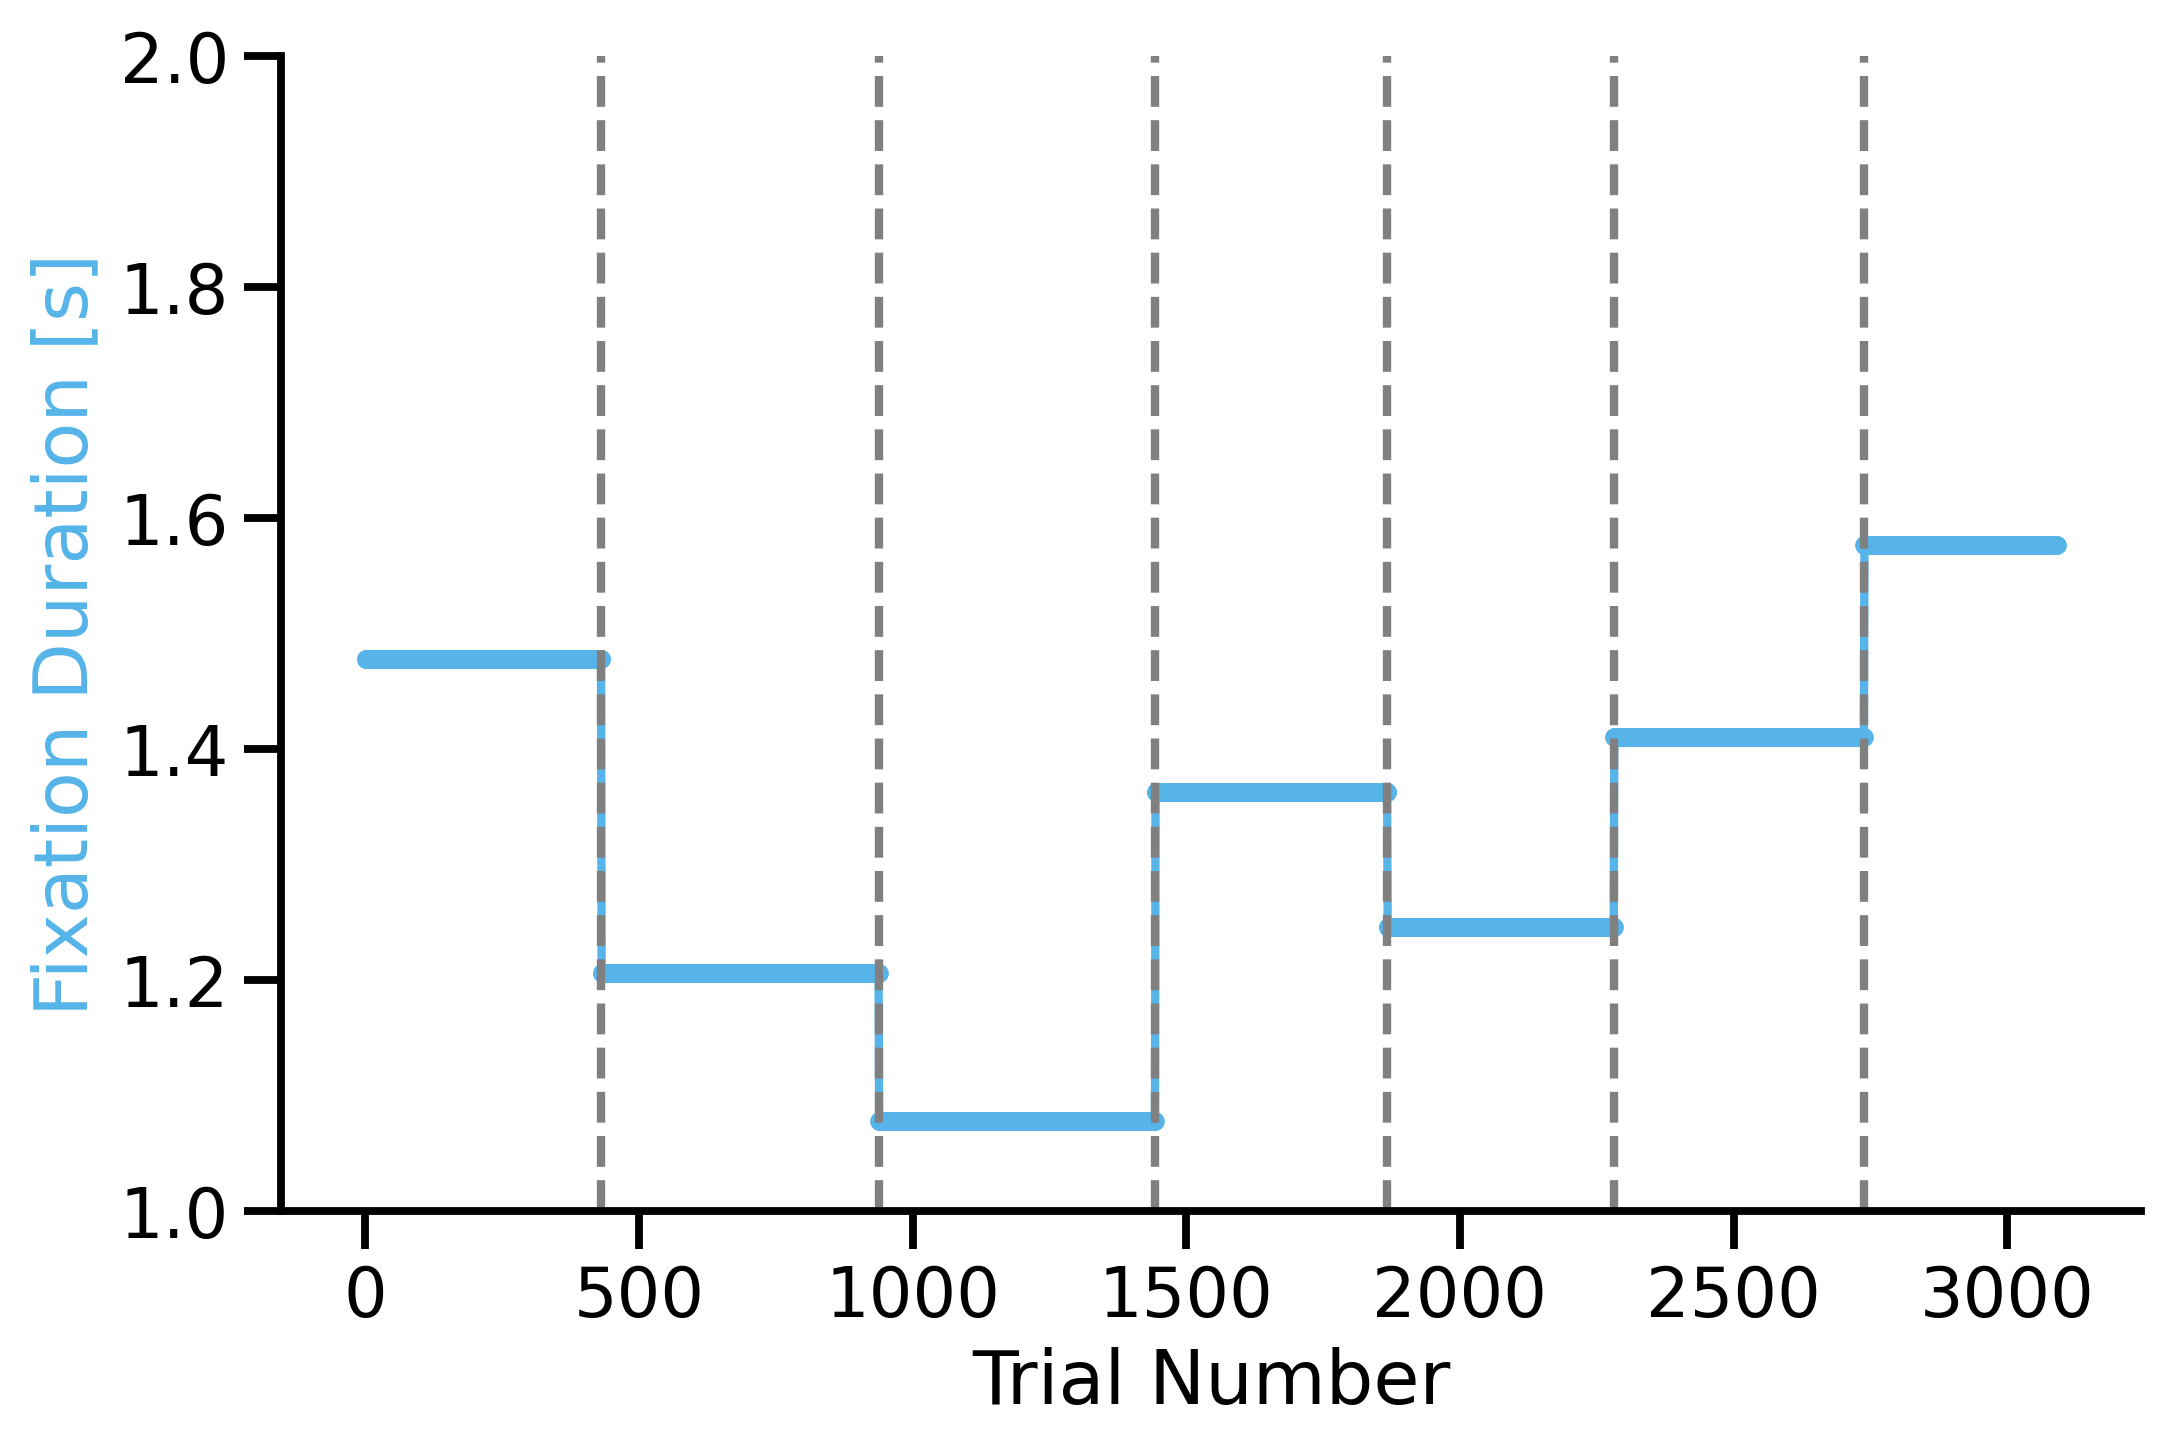

In [146]:
N_EXAMPLE_SESSIONS = 7
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
sns.despine()

plot_df = example_tdf.query("days_relative_to_stage_11_adj <= @N_EXAMPLE_SESSIONS")
sns.lineplot(data=plot_df, x="cumulative_trial", y="fixation_dur", color=c.V2_COLOR, marker=".",markeredgecolor="none", lw=2, ax=ax)


# Find the unique session start points
session_starts = plot_df.groupby("sess_id")["cumulative_trial"].min() - 1

# Plot a vertical line at the start of each new session
for session_start in session_starts:
    if session_start > 0:
        ax.axvline(x=session_start, color="gray", linestyle="--", lw=2)


ax.set(xlabel="Trial Number", title="", ylim=(1, 2))
ax.set_ylabel("Fixation Duration [s]", color=c.V2_COLOR)
# ax.set_title(f"{EXAMPLE_ANIMAL} Fixation Requirements", fontweight="bold")

c.save_fig(fig, "fig6_example_fix_durations")


# 2. Distribution of Session Fix Durs


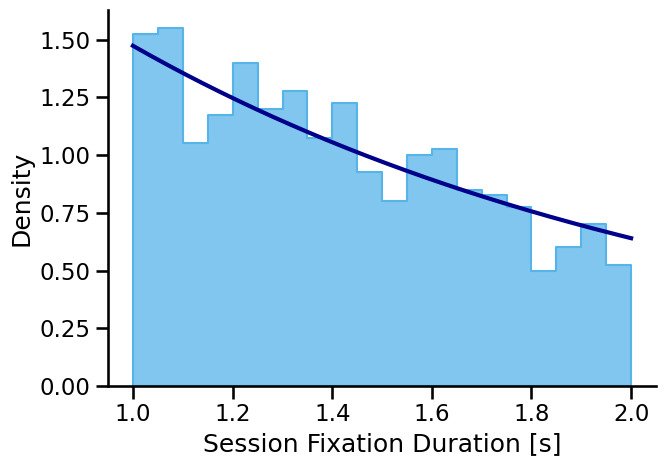

In [144]:
N_SESSIONS = 100


fix_dur_df = tdf.query("days_relative_to_stage_11_adj <= @N_SESSIONS").groupby(["animal_id", "date"]).fixation_dur.max().reset_index()

fig, ax = plt.subplots(figsize=(7,5))
sns.despine()
sns.histplot(data=fix_dur_df, x="fixation_dur", binwidth=0.05, color=c.V2_COLOR, element="step", stat="density", ax=ax)

# 2. Truncated‐exp PDF
tau = 1.2
a, b = 1.0, 2.0
x = np.linspace(a, b, 200)
Z = np.exp(-a/tau) - np.exp(-b/tau)
pdf = (1/tau) * np.exp(-x/tau) / Z
ax.plot(x, pdf, lw=3, color="darkblue")

# 5. Legends & labels
ax.set_xlabel("Session Fixation Duration [s]")
# ax.legend(loc="upper right", frameon=False)
# ax.set_title(f"Distribution of Fixation Requirements", fontweight="bold")

plt.tight_layout()
plt.show()
c.save_fig(fig, "fig6_dist_of_fix_durations")


# 3. Violation Rate Over Days


In [103]:
stage11_summary_df = tdf.query("days_relative_to_stage_11_adj <= @N_SESSIONS").groupby(["animal_id", "days_relative_to_stage_11_adj"]).agg(
    violation_rate=("violation_rate", "mean"),
    n_trials=("trial", "count"),
    fixation_duration=("fixation_dur", "max"),
).reset_index()

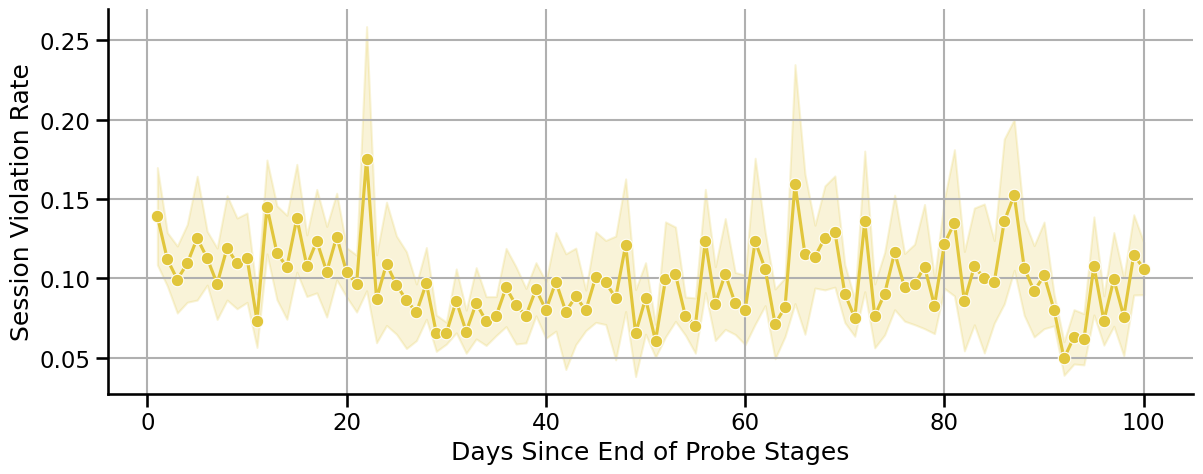

In [145]:

fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(data=stage11_summary_df, x="days_relative_to_stage_11_adj", y="violation_rate", ax=ax, errorbar="se", marker="o", color=c.VIOLATION_COLOR)

ax.grid(True)

ax.set(
    xlabel="Days Since End of Probe Stages",
    ylabel="Session Violation Rate",
    # ylim=(0, 0.5)
)

# ax.set_title("Violation Rate Post-Probe Stages", fontweight="bold")

sns.despine()
c.save_fig(fig, "fig6_over_time_violation_rate")




In [107]:
stats = stage11_summary_df['violation_rate'].agg(['median', 'mean', 'std', 'size']).reset_index()
stats

,index,violation_rate
0,median,0.072692
1,mean,0.098968
2,std,0.082594
3,size,800.000000


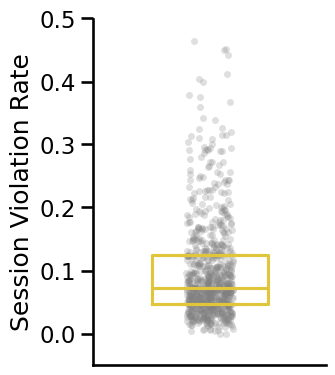

In [142]:
fig, ax = plt.subplots(figsize=(3,4.5))
sns.despine()

sns.boxplot(
    y="violation_rate",
    data=stage11_summary_df,
    ax=ax,
    color=c.VIOLATION_COLOR,
    fill=False,
    showfliers=False,
    whis=0,
    width=0.5,
    zorder=10
)


sns.stripplot(
    y="violation_rate",
    data=stage11_summary_df,
    ax=ax,
    color="gray",
    legend=False,
    alpha=0.25,
)
ax.set(
    ylabel="Session Violation Rate",
    ylim=(-0.05,0.5),
    xticks=[]
)
# ax.set_title(f"Summary\nViolation Rate", fontweight="bold")

c.save_fig(fig, "fig6_over_time_violation_rate_summary")
